# Stock value prediction from Open, High, Low

# Import module

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py

# Input parameters 

In [26]:
stock_name = '^GSPC'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

# 1. Download data and normalize it
Data since 1950 to today

In [27]:
def get_stock_data(stock_name, normalize=True):
    start = datetime.datetime(1950, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Volume', 'Close'], 1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df

df = get_stock_data(stock_name, normalize=True)

# 2. Plot out the Normalized Adjusted close price

                Open      High       Low  Adj Close
Date                                               
1950-01-03  0.000000  0.000000  0.000000   0.000000
1950-01-04  0.000080  0.000080  0.000080   0.000080
1950-01-05  0.000114  0.000113  0.000114   0.000113
1950-01-06  0.000135  0.000134  0.000135   0.000134
1950-01-09  0.000177  0.000176  0.000177   0.000177


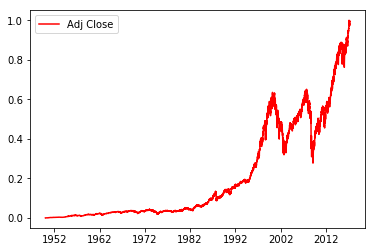

In [28]:
def plot_stock(stock_name):
    df = get_stock_data(stock_name, normalize=True)
    print(df.head())
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()

plot_stock(stock_name)

# 3. Set last day Adjusted Close as y

In [29]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features # (3893, 23, 4)
    X_train = train[:, :-1] # x = all feature except adj close # (3893, 22, 4)
    y_train = train[:, -1][:,-1] # y = last feature, last day (3893)
    X_test = result[int(row):, :-1] #(432, 22, 4)
    y_test = result[int(row):, -1][:,-1] #(432)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

X_train, y_train, X_test, y_test = load_data(df, seq_len)

# 4. Buidling neural network

In [30]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# 6. Model Execution

In [41]:
model = build_model2(shape, neurons, d)
# layers = [4, 22, 1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_21 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 13702 samples, validate on 1523 samples
Epoch 1/300
13702/13702 [==============================] - 3s - loss: 0.0123 - acc: 0.0000e+00 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 2/300
13702/13702 [==============================] - 1s - loss: 6.7706e-04 - acc: 0.0000e+00 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 3/300
13702/13702 [==============================] - 1s - loss: 2.7348e-04 - acc: 0.0000e+00 - val_loss: 6.3644e-04 - val_acc: 0.0000e+00
Epoch 4/300
13702/13702 [==============================] - 1s - loss: 1.7076e-04 - acc: 0.0000e+00 - val_loss: 3.7487e-04 - val_acc: 0.0000e+00
Epoch 5/300
13702/13702 [==============================] - 1s - loss: 1.4376e-04 - acc: 0.0000e+00 - val_loss: 3.0687e-04 - val_acc: 0.0000e+00
Epoch 6/300
13702/13702 [==============================] - 1s - loss: 1.4102e-04 - acc: 0.0000e+00 - val_loss: 2.5381e-04 - val_acc: 0.0000e+00
Epoch 7/300
13702/13702 [==============================] - 1s - loss: 1.2676e-04 - acc: 0.0000e+00 

13702/13702 [==============================] - 1s - loss: 7.9500e-05 - acc: 0.0000e+00 - val_loss: 1.6054e-04 - val_acc: 0.0000e+00
Epoch 58/300
13702/13702 [==============================] - 1s - loss: 8.0208e-05 - acc: 0.0000e+00 - val_loss: 1.3967e-04 - val_acc: 0.0000e+00
Epoch 59/300
13702/13702 [==============================] - 1s - loss: 8.3925e-05 - acc: 0.0000e+00 - val_loss: 1.3662e-04 - val_acc: 0.0000e+00
Epoch 60/300
13702/13702 [==============================] - 1s - loss: 7.8319e-05 - acc: 0.0000e+00 - val_loss: 2.6067e-04 - val_acc: 0.0000e+00
Epoch 61/300
13702/13702 [==============================] - 1s - loss: 8.9368e-05 - acc: 0.0000e+00 - val_loss: 2.0857e-04 - val_acc: 0.0000e+00
Epoch 62/300
13702/13702 [==============================] - 1s - loss: 8.1368e-05 - acc: 0.0000e+00 - val_loss: 2.0302e-04 - val_acc: 0.0000e+00
Epoch 63/300
13702/13702 [==============================] - 1s - loss: 7.8229e-05 - acc: 0.0000e+00 - val_loss: 1.3445e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 5.9237e-05 - acc: 0.0000e+00 - val_loss: 1.1493e-04 - val_acc: 0.0000e+00
Epoch 114/300
13702/13702 [==============================] - 1s - loss: 6.1312e-05 - acc: 0.0000e+00 - val_loss: 1.0902e-04 - val_acc: 0.0000e+00
Epoch 115/300
13702/13702 [==============================] - 1s - loss: 5.9865e-05 - acc: 0.0000e+00 - val_loss: 1.2336e-04 - val_acc: 0.0000e+00
Epoch 116/300
13702/13702 [==============================] - 1s - loss: 5.6883e-05 - acc: 0.0000e+00 - val_loss: 1.0724e-04 - val_acc: 0.0000e+00
Epoch 117/300
13702/13702 [==============================] - 1s - loss: 5.8860e-05 - acc: 0.0000e+00 - val_loss: 1.2652e-04 - val_acc: 0.0000e+00
Epoch 118/300
13702/13702 [==============================] - 1s - loss: 6.0152e-05 - acc: 0.0000e+00 - val_loss: 1.1456e-04 - val_acc: 0.0000e+00
Epoch 119/300
13702/13702 [==============================] - 1s - loss: 5.8167e-05 - acc: 0.0000e+00 - val_loss: 1.1338e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 4.3286e-05 - acc: 0.0000e+00 - val_loss: 8.2068e-05 - val_acc: 0.0000e+00
Epoch 170/300
13702/13702 [==============================] - 1s - loss: 4.8856e-05 - acc: 0.0000e+00 - val_loss: 8.1019e-05 - val_acc: 0.0000e+00
Epoch 171/300
13702/13702 [==============================] - 1s - loss: 4.4046e-05 - acc: 0.0000e+00 - val_loss: 7.9796e-05 - val_acc: 0.0000e+00
Epoch 172/300
13702/13702 [==============================] - 1s - loss: 4.4647e-05 - acc: 0.0000e+00 - val_loss: 3.4785e-04 - val_acc: 0.0000e+00
Epoch 173/300
13702/13702 [==============================] - 1s - loss: 4.3621e-05 - acc: 0.0000e+00 - val_loss: 7.7378e-05 - val_acc: 0.0000e+00
Epoch 174/300
13702/13702 [==============================] - 1s - loss: 4.3630e-05 - acc: 0.0000e+00 - val_loss: 1.4229e-04 - val_acc: 0.0000e+00
Epoch 175/300
13702/13702 [==============================] - 1s - loss: 4.5626e-05 - acc: 0.0000e+00 - val_loss: 8.6298e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 4.2122e-05 - acc: 0.0000e+00 - val_loss: 8.8204e-05 - val_acc: 0.0000e+00
Epoch 226/300
13702/13702 [==============================] - 1s - loss: 4.0988e-05 - acc: 0.0000e+00 - val_loss: 9.4153e-05 - val_acc: 0.0000e+00
Epoch 227/300
13702/13702 [==============================] - 1s - loss: 3.5446e-05 - acc: 0.0000e+00 - val_loss: 8.0506e-05 - val_acc: 0.0000e+00
Epoch 228/300
13702/13702 [==============================] - 1s - loss: 3.7963e-05 - acc: 0.0000e+00 - val_loss: 1.0311e-04 - val_acc: 0.0000e+00
Epoch 229/300
13702/13702 [==============================] - 1s - loss: 4.0119e-05 - acc: 0.0000e+00 - val_loss: 6.7661e-05 - val_acc: 0.0000e+00
Epoch 230/300
13702/13702 [==============================] - 1s - loss: 4.7685e-05 - acc: 0.0000e+00 - val_loss: 6.3728e-05 - val_acc: 0.0000e+00
Epoch 231/300
13702/13702 [==============================] - 1s - loss: 3.9021e-05 - acc: 0.0000e+00 - val_loss: 6.4773e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.3599e-05 - acc: 0.0000e+00 - val_loss: 6.4390e-05 - val_acc: 0.0000e+00
Epoch 282/300
13702/13702 [==============================] - 1s - loss: 3.8564e-05 - acc: 0.0000e+00 - val_loss: 7.8942e-05 - val_acc: 0.0000e+00
Epoch 283/300
13702/13702 [==============================] - 1s - loss: 3.5432e-05 - acc: 0.0000e+00 - val_loss: 6.9701e-05 - val_acc: 0.0000e+00
Epoch 284/300
13702/13702 [==============================] - 1s - loss: 3.6280e-05 - acc: 0.0000e+00 - val_loss: 7.1961e-05 - val_acc: 0.0000e+00
Epoch 285/300
13702/13702 [==============================] - 1s - loss: 4.4807e-05 - acc: 0.0000e+00 - val_loss: 1.9348e-04 - val_acc: 0.0000e+00
Epoch 286/300
13702/13702 [==============================] - 1s - loss: 3.5989e-05 - acc: 0.0000e+00 - val_loss: 6.2614e-05 - val_acc: 0.0000e+00
Epoch 287/300
13702/13702 [==============================] - 1s - loss: 3.3820e-05 - acc: 0.0000e+00 - val_loss: 9.6478e-05 - val_acc: 0.0

# 7. Result on training set and testing set

In [43]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]
    
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00002 MSE (0.00 RMSE)
Test Score: 0.00012 MSE (0.01 RMSE)


(2.3023599784263853e-05, 0.00012482673341001607)

# 8. Prediction vs Real results

In [44]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

p = percentage_difference(model, X_test, y_test)

# 9. Plot out prediction

In [45]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    
    df = df['Adj Close'][-round(0.9 * len(df)):].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

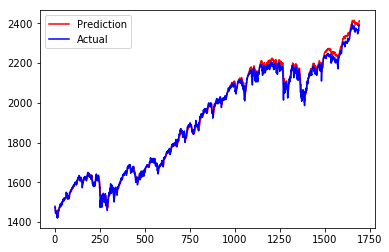

In [46]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.show()

plot_result(stock_name, p, y_test)

# 10. Save for consistency

In [47]:
model.save('LSTM_Stock_prediction-20170429.h5')

# Part 2. Fine tune model
# 11. Function to load data, train model and see score

In [48]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

In [ ]:
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model2(shape, neurons, d)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

# 12. Fine tune hyperparameter

12.1 Optimial Dropout value

In [ ]:
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
neurons_LSTM = [32, 64, 128, 256, 512, 1024, 2048]

for d in dlist:
    dropout_result = {}
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    dropout_result[d] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_23 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

13702/13702 [==============================] - 1s - loss: 9.4744e-05 - acc: 0.0000e+00 - val_loss: 2.4658e-04 - val_acc: 0.0000e+00
Epoch 50/300
13702/13702 [==============================] - 1s - loss: 9.4697e-05 - acc: 0.0000e+00 - val_loss: 7.1417e-04 - val_acc: 0.0000e+00
Epoch 51/300
13702/13702 [==============================] - 1s - loss: 9.9894e-05 - acc: 0.0000e+00 - val_loss: 1.7327e-04 - val_acc: 0.0000e+00
Epoch 52/300
13702/13702 [==============================] - 1s - loss: 8.6464e-05 - acc: 0.0000e+00 - val_loss: 1.9872e-04 - val_acc: 0.0000e+00
Epoch 53/300
13702/13702 [==============================] - 1s - loss: 8.4104e-05 - acc: 0.0000e+00 - val_loss: 1.4537e-04 - val_acc: 0.0000e+00
Epoch 54/300
13702/13702 [==============================] - 1s - loss: 7.9031e-05 - acc: 0.0000e+00 - val_loss: 1.5018e-04 - val_acc: 0.0000e+00
Epoch 55/300
13702/13702 [==============================] - 1s - loss: 8.0498e-05 - acc: 0.0000e+00 - val_loss: 1.9391e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 6.0134e-05 - acc: 0.0000e+00 - val_loss: 1.1251e-04 - val_acc: 0.0000e+00
Epoch 106/300
13702/13702 [==============================] - 1s - loss: 6.2084e-05 - acc: 0.0000e+00 - val_loss: 9.9580e-05 - val_acc: 0.0000e+00
Epoch 107/300
13702/13702 [==============================] - 1s - loss: 7.0559e-05 - acc: 0.0000e+00 - val_loss: 1.0106e-04 - val_acc: 0.0000e+00
Epoch 108/300
13702/13702 [==============================] - 1s - loss: 6.6692e-05 - acc: 0.0000e+00 - val_loss: 3.9671e-04 - val_acc: 0.0000e+00
Epoch 109/300
13702/13702 [==============================] - 1s - loss: 6.4779e-05 - acc: 0.0000e+00 - val_loss: 2.5309e-04 - val_acc: 0.0000e+00
Epoch 110/300
13702/13702 [==============================] - 1s - loss: 6.9265e-05 - acc: 0.0000e+00 - val_loss: 1.9515e-04 - val_acc: 0.0000e+00
Epoch 111/300
13702/13702 [==============================] - 1s - loss: 6.4985e-05 - acc: 0.0000e+00 - val_loss: 9.7191e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 4.9750e-05 - acc: 0.0000e+00 - val_loss: 1.5147e-04 - val_acc: 0.0000e+00
Epoch 162/300
13702/13702 [==============================] - 1s - loss: 4.2750e-05 - acc: 0.0000e+00 - val_loss: 8.4485e-05 - val_acc: 0.0000e+00
Epoch 163/300
13702/13702 [==============================] - 1s - loss: 4.1993e-05 - acc: 0.0000e+00 - val_loss: 8.8429e-05 - val_acc: 0.0000e+00
Epoch 164/300
13702/13702 [==============================] - 1s - loss: 4.8208e-05 - acc: 0.0000e+00 - val_loss: 1.3213e-04 - val_acc: 0.0000e+00
Epoch 165/300
13702/13702 [==============================] - 1s - loss: 4.8998e-05 - acc: 0.0000e+00 - val_loss: 2.2894e-04 - val_acc: 0.0000e+00
Epoch 166/300
13702/13702 [==============================] - 1s - loss: 4.6933e-05 - acc: 0.0000e+00 - val_loss: 8.4207e-05 - val_acc: 0.0000e+00
Epoch 167/300
13702/13702 [==============================] - 1s - loss: 4.2394e-05 - acc: 0.0000e+00 - val_loss: 7.7307e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.5140e-05 - acc: 0.0000e+00 - val_loss: 6.3795e-05 - val_acc: 0.0000e+00
Epoch 218/300
13702/13702 [==============================] - 1s - loss: 3.3937e-05 - acc: 0.0000e+00 - val_loss: 7.4056e-05 - val_acc: 0.0000e+00
Epoch 219/300
13702/13702 [==============================] - 1s - loss: 3.5262e-05 - acc: 0.0000e+00 - val_loss: 8.0809e-05 - val_acc: 0.0000e+00
Epoch 220/300
13702/13702 [==============================] - 1s - loss: 3.5615e-05 - acc: 0.0000e+00 - val_loss: 6.4038e-05 - val_acc: 0.0000e+00
Epoch 221/300
13702/13702 [==============================] - 1s - loss: 3.6467e-05 - acc: 0.0000e+00 - val_loss: 7.0325e-05 - val_acc: 0.0000e+00
Epoch 222/300
13702/13702 [==============================] - 1s - loss: 3.4067e-05 - acc: 0.0000e+00 - val_loss: 7.2915e-05 - val_acc: 0.0000e+00
Epoch 223/300
13702/13702 [==============================] - 1s - loss: 3.3146e-05 - acc: 0.0000e+00 - val_loss: 1.0270e-04 - val_acc: 0.0

In [ ]:
min_val = min(dropout_result.values())
min_val_key = [k for k, v in dropout_result.items() if v == min_val]
print (min_val_key)

12.2 Optimial epochs value

12.3 Optimal number of neurons